# Подбор параметров ядра

На прошлом занятии мы научились делать регрессию, используя гауссовские процессы с заданной фиксированной ковариационной функцией.
Однако во многих практических приложениях указать ковариационную функцию может быть затруднительно.
Обычно мы имеем достаточно расплывчатую информацию о свойствах, например, о значении свободных (гипер-) параметров, например, о длинах.
Таким образом, необходимо разработать методы, решающие проблему выбора модели и значений гиперпараметров.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Влияние-параметров-ядра-и-амплитуды-шума" data-toc-modified-id="Влияние-параметров-ядра-и-амплитуды-шума-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Влияние параметров ядра и амплитуды шума</a></span><ul class="toc-item"><li><span><a href="#Используемые-функции" data-toc-modified-id="Используемые-функции-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Используемые функции</a></span></li><li><span><a href="#Тренировочные-данные" data-toc-modified-id="Тренировочные-данные-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Тренировочные данные</a></span></li><li><span><a href="#Варьирование-параметров-ядра-и-амплитуды-шума" data-toc-modified-id="Варьирование-параметров-ядра-и-амплитуды-шума-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Варьирование параметров ядра и амплитуды шума</a></span></li></ul></li><li><span><a href="#Оптимизация-параметров-ядра" data-toc-modified-id="Оптимизация-параметров-ядра-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Оптимизация параметров ядра</a></span><ul class="toc-item"><li><span><a href="#Двумерное-пространство" data-toc-modified-id="Двумерное-пространство-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Двумерное пространство</a></span></li></ul></li><li><span><a href="#Литература" data-toc-modified-id="Литература-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Литература</a></span></li></ul></div>

In [2]:
# Imports
import sys
sys.path.append('../modules')
import graph_utils

import numpy as np
import numpy.linalg as LA
np.random.seed(42)
from scipy.optimize import minimize

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [18]:
# Styles
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['lines.linewidth'] = 2.
matplotlib.rcParams['lines.markersize'] = 10
# cm = plt.cm.tab10  # Colormap

import seaborn
seaborn.set_style('whitegrid')
figscale = 2

from IPython.display import display, Markdown

In [4]:
%%html
<style>
    .container.slides .celltoolbar, .container.slides .hide-in-slideshow {display: None ! important;}
</style>

## Влияние параметров ядра и амплитуды шума ##

### Используемые функции ###

На предыдущих занятиях мы использовали квадратичное экспоненциальное ядро:

$$ k(x_a, x_b) = \sigma_f^2 \exp{ \left( -\frac{1}{2l^2} \lVert x_a - x_b \rVert^2 \right) }. $$

Теперь пришло время поиграть с параметрами ядра: ширины ядра $l$ и амплитуды $\sigma_f$.

Ниже приводятся уже знакомые нам функции `kernel()`, `plot_gp()` и `posterior_predictive()`.

In [5]:
# Isotropic squared exponential kernel.
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    
    sqdist = np.sum(X1**2,1).reshape(-1,1) + np.sum(X2**2,1) - 2*np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [6]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[], ylim=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(
        X, mu + uncertainty, mu - uncertainty,
        color='grey', alpha=0.1, label='95% доверительный интервал')
    for sample in enumerate(samples):
        plt.plot(X, sample, '-', lw=1.0)
    plt.plot(X, mu, 'k', label='среднее значение')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'x', c=cm.tab10(3), mew=1.5)
    plt.xlim([X.min(), X.max()])
    if ylim:
        plt.ylim(ylim)

In [7]:
def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffiсient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = LA.inv(K)
    
    # mean vector
    mu_s = K_s.T @ K_inv @ Y_train

    # covariance matrix
    cov_s = K_ss - K_s.T @ K_inv @K_s
    
    return mu_s, cov_s

### Тренировочные данные ###

В качестве обучающей выборки будем использовать данные из предыдущего занятия.

In [8]:
# Data
x_min, x_max = 0., 10.
N_test = 1001
X_test = np.linspace(x_min, x_max, N_test).reshape(-1,1)

X_train = np.array([2.,  6.,  7., 8.,  4., 3. ]).reshape(-1, 1)
Y_train = np.array([1., -1., -1., 0.5, 1., 0.5]).reshape(-1, 1)

### Варьирование параметров ядра и амплитуды шума ###

В следующем примере показано влияние параметров ядра $l$ и $\sigma_f$, а также амплитуды шума $\sigma_y$.

In [9]:
params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

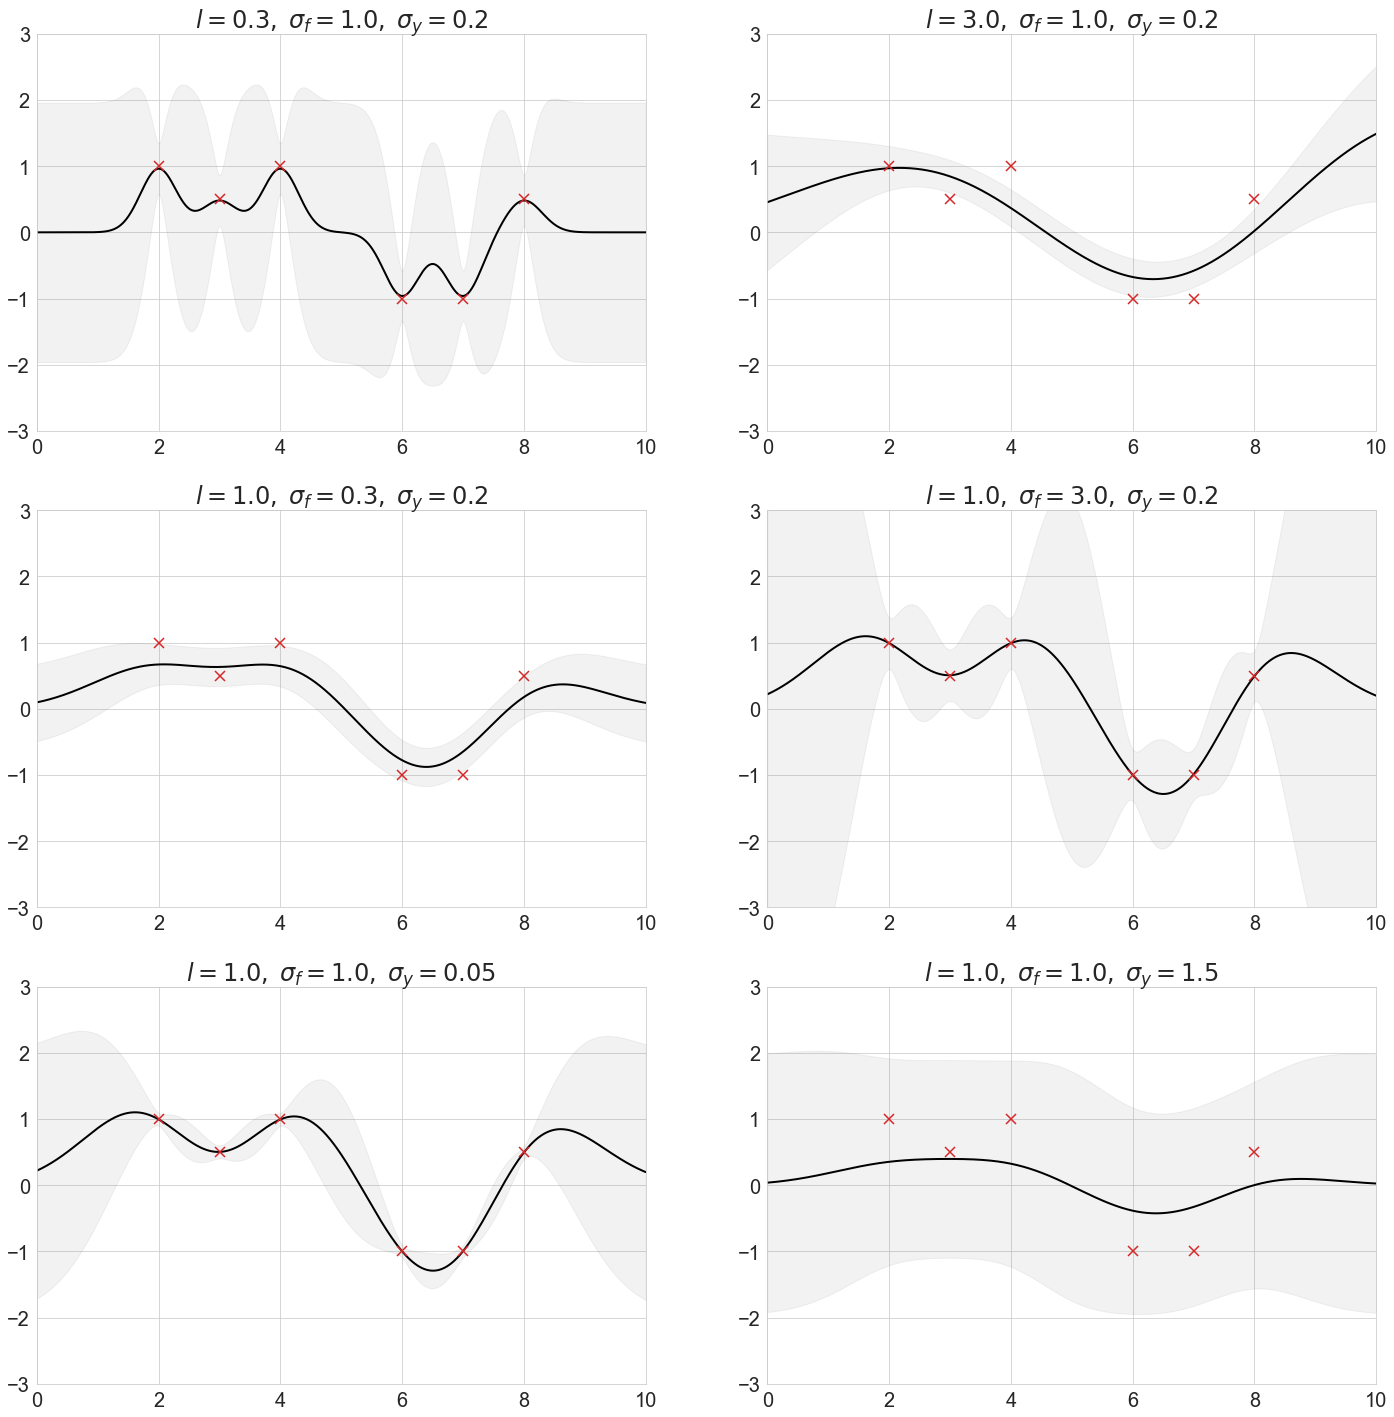

In [10]:
graph_utils.hide_code_in_slideshow()

plt.figure(figsize=(figscale*12, figscale*5))
for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(
        X_test, X_train, Y_train,
        l=l, sigma_f=sigma_f, sigma_y=sigma_y)
    plt.subplot(3, 2, i+1)
    plt.subplots_adjust(top=2)
    plt.title(f'$l = {l},\;\sigma_f = {sigma_f},\;\sigma_y = {sigma_y}$')
    plot_gp(mu_s, cov_s, X_test, X_train=X_train, Y_train=Y_train, ylim=[-3, 3])

По рисункам можно сделать следующие выводы:

1. Малое значения $l$ приводит к достаточно &laquo;изогнутой&raquo; средней функции с большими доверительными интервалами между точками обучающей выборки.
Большое значение ширины ядра $l$ даёт более гладкую регрессионную функцию, но более грубую аппроксимацию обучающих данных.
2. Параметр $\sigma_f$ контролирует вертикальную вариативность функций, взятых из GP.
Это видно по большим доверительным интервалам за пределами области тренировочных данных на правом рисунке второй строки.
3. Параметр $\sigma_y$ представляет собой уровень шума в обучающих данных.
Более высокое значение $\sigma_y$ приводит к более грубой аппроксимации, но позволяет избежать подгонки под шумные данные.

## Оптимизация параметров ядра ##

Оптимальные значения параметров ядра (гиперпарамтров) могут быть оценены путём максимизации логарифма правдоподобия.

$$
\log p(\mathbf{y} \lvert \mathbf{X}) = 
\log \mathcal{N}(\mathbf{y} \lvert \boldsymbol{0},\mathbf{K}_y) =
-\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y} 
-\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_y\end{vmatrix} 
-\frac{N}{2} \log(2\pi) \tag{1}
$$

In [49]:
def nll_fn(X_train, Y_train, sigma_y):
    '''
    Returns a function that computes the negative marginal log-
    likelihood for training data X_train and Y_train and given 
    noise level.
    
    Args:
        X_train: training locations (m x d)
        Y_train: training targets (m x 1)
        noise: known noise level of Y_train
        
    Returns:
        Minimization objective
    '''
    def nll(theta):
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            sigma_y**2 * np.eye(len(X_train))
        y = np.log(LA.det(K)) + Y_train.T @ LA.inv(K) @ Y_train
        return y.flatten()
    
    return nll

In [59]:
sigma_y = 0.1
res = minimize(nll_fn(X_train, Y_train, sigma_y), [1, 1],
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')
l_opt, sigma_f_opt = res.x

display(Markdown(rf'$l = {l_opt:.3},\;\sigma_f = {sigma_f_opt:.3},\;\sigma_y = {sigma_y:.3}$'))

$l = 0.778,\;\sigma_f = 0.852,\;\sigma_y = 0.1$

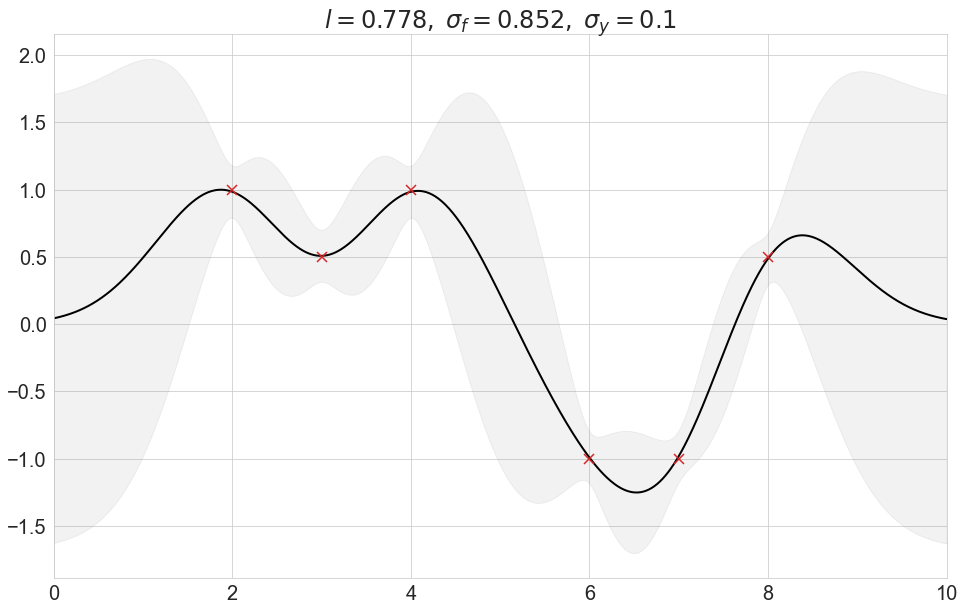

In [60]:
graph_utils.hide_code_in_slideshow()

# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(
    X_test, X_train, Y_train,
    l=l_opt, sigma_f=sigma_f_opt, sigma_y=sigma_y
)
plt.figure(figsize=(figscale*8, figscale*5))
plt.title(f'$l = {l_opt:.3},\;\sigma_f = {sigma_f_opt:.3},\;\sigma_y = {sigma_y:.3}$')
plot_gp(mu_s, cov_s, X_test, X_train=X_train, Y_train=Y_train)

In [61]:
def nll_fn_2(X_train, Y_train):
    '''
    Returns a function that computes the negative marginal log-
    likelihood for training data X_train and Y_train and given 
    noise level.
    
    Args:
        X_train: training locations (m x d)
        Y_train: training targets (m x 1)
        noise: known noise level of Y_train
        
    Returns:
        Minimization objective.
    '''
    def nll_2(theta):
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            theta[2]**2 * np.eye(len(X_train))
        y = np.log(LA.det(K)) + Y_train.T @ LA.inv(K) @ Y_train
        return y.flatten()
    
    return nll_2

In [62]:
res = minimize(nll_fn_2(X_train, Y_train), [1, 1, 1], 
               bounds=((1e-5, None), (1e-5, None), (1e-5, None)),
               method='L-BFGS-B')
l_opt, sigma_f_opt, sigma_y_opt = res.x

display(Markdown(rf'$l = {l_opt:.2},\;\sigma_f = {sigma_f_opt:.2},\;\sigma_y = {sigma_y_opt:.2}$'))

$l = 0.77,\;\sigma_f = 0.86,\;\sigma_y = 1e-05$

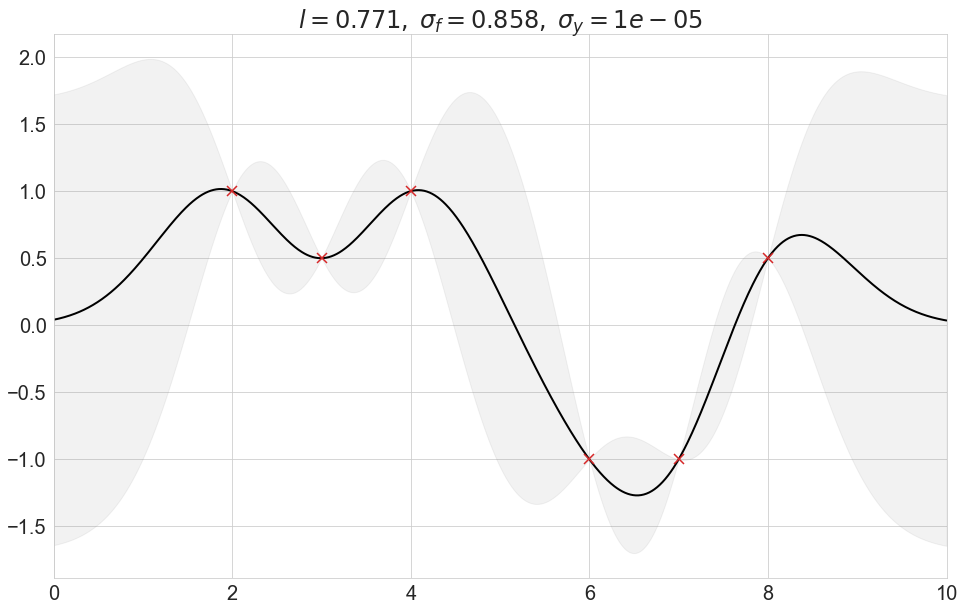

In [58]:
graph_utils.hide_code_in_slideshow()

# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(
    X_test, X_train, Y_train,
    l=l_opt, sigma_f=sigma_f_opt, sigma_y=sigma_y_opt
)
plt.figure(figsize=(figscale*8, figscale*5))
plt.title(f'$l = {l_opt:.3},\;\sigma_f = {sigma_f_opt:.3},\;\sigma_y = {sigma_y_opt:.3}$')
plot_gp(mu_s, cov_s, X_test, X_train=X_train, Y_train=Y_train)

### Двумерное пространство

In [63]:
from mpl_toolkits.mplot3d import Axes3D

def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)

In [64]:
N_train = 100
noise_2D_train = 0.01
noise_2D_model = 0.02


rx, ry = np.arange(-5, 5, 0.2), np.arange(-5, 5, 0.2)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (N_train, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D_train * np.random.randn(len(X_2D_train))

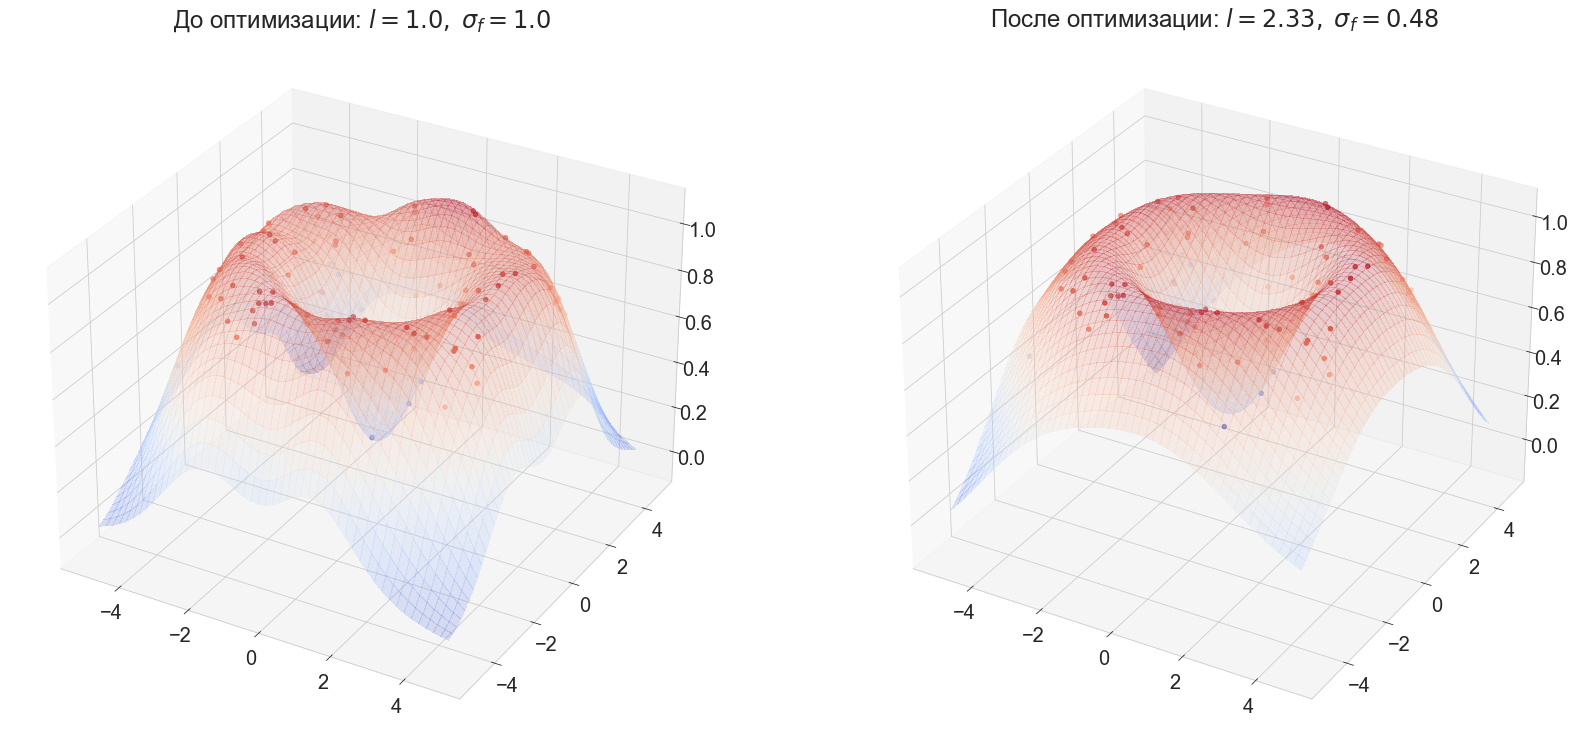

In [66]:
graph_utils.hide_code_in_slideshow()

plt.figure(figsize=(figscale*14,figscale*7))

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D_model)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
           f'До оптимизации: $l={1.00},\;\sigma_f={1.00}$', 1)

res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D_model), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D_model)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
           f'После оптимизации: $l={res.x[0]:.2f},\;\sigma_f={res.x[1]:.2f}$', 2)

## Литература

1. Kevin P. Murphy. [Machine Learning, A Probabilistic Perspective](https://mitpress.mit.edu/books/machine-learning-0), Chapters 4, 14 and 15.  
1. Christopher M. Bishop. [Pattern Recognition and Machine Learning](http://www.springer.com/de/book/9780387310732), Chapter 6. 
1. Carl Edward Rasmussen and Christopher K. I. Williams. [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/).  